In [1]:
import pandas as pd
import numpy as np

df1 = pd.read_csv("anomaly_dataset.csv")
df1.head()

,Year,Month,Day,Customer Number,Order Number,Order Item,Product,Sales Quantity,Unit of Measure,Revenue,Currency,Discount,Anomaly
0,2009,5,3,16795,101630,150,PRD1571,1,ST,3308.530,USD,178.64,0
1,2009,9,16,1860,101432,140,PRD2569,1,ST,3310.590,USD,74.03,0
2,2010,6,2,6390,101264,110,PRD4579,1,ST,4241.140,USD,137.93,0
3,2010,11,6,12964,101953,80,PRD8394,1,ST,3761.610,EUR,157.04,0
4,2010,11,28,12284,101428,40,PRD5226,50,ST,225.395,USD,602.70,1


# 10-fold cross validation


## Using all features

C:\Users\Hp\AppData\Local\Temp\ipykernel_19916\783216653.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


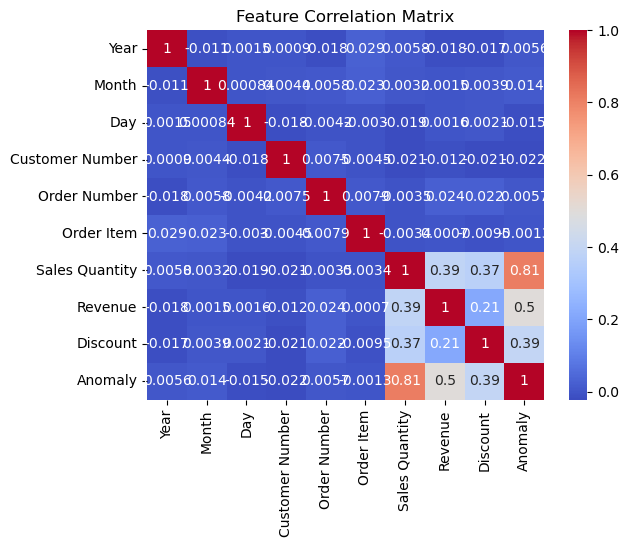


Evaluating Local Outlier Factor (LOF) with 10-Fold Cross Validation...
Accuracy: 0.9914
Precision: 0.9117
Recall: 0.9200
F1 Score: 0.9144
ROC AUC Score: 0.9576
Execution Time: 9.42 seconds

Evaluating One-Class SVM with 10-Fold Cross Validation...
Accuracy: 0.9692
Precision: 0.6741
Recall: 0.7560
F1 Score: 0.7109
ROC AUC Score: 0.8682
Execution Time: 1.56 seconds

Evaluating Isolation Forest with 10-Fold Cross Validation...
Accuracy: 0.9830
Precision: 0.8341
Recall: 0.8280
F1 Score: 0.8295
ROC AUC Score: 0.9096
Execution Time: 4.36 seconds

Evaluating Robust Covariance with 10-Fold Cross Validation...


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:745: User

Accuracy: 0.9900
Precision: 0.9021
Recall: 0.9000
F1 Score: 0.9001
ROC AUC Score: 0.9474
Execution Time: 4.53 seconds


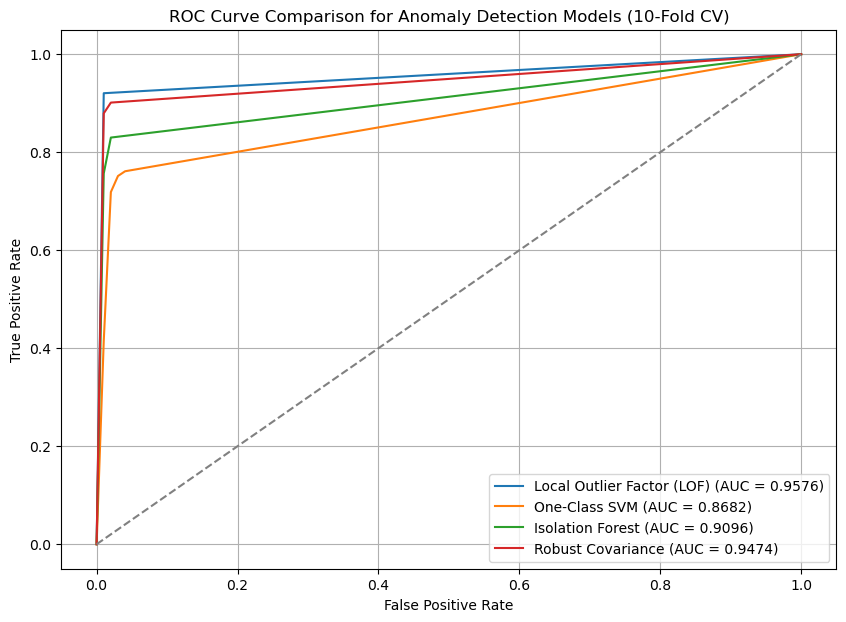

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve

# Load dataset
df = pd.read_csv("anomaly_dataset.csv")

# Feature relevance analysis
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


# Encode categorical variables
label_encoders = {}
for col in ["Currency", "Product", "Unit of Measure"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

    
# all features except target
features = [col for col in df.columns if col != "Anomaly"]

X = df[features]
y = df["Anomaly"]  # 0 = Normal, 1 = Anomaly

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize models
models = {
    "Local Outlier Factor (LOF)": LocalOutlierFactor(n_neighbors=80, contamination=0.05, metric='manhattan', novelty=True),
    "One-Class SVM": OneClassSVM(nu=0.05, kernel="rbf", gamma="auto"),
    "Isolation Forest": IsolationForest(n_estimators=100, contamination=0.05, random_state=42),
    "Robust Covariance": EllipticEnvelope(contamination=0.05)
}

# Setting up 10-Fold Stratified Cross Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Storing results
evaluation_results = {}
roc_curves = {}

for name, model in models.items():
    print(f"\nEvaluating {name} with 10-Fold Cross Validation...")

    model_time = 0.0  # time spent on model training + prediction

    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    roc_aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    for train_index, test_index in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Timing only the model's fit + predict process
        start = time.time()
        if isinstance(model, LocalOutlierFactor):
            model.fit(X_train)
            y_pred_test = model.predict(X_test)
        else:
            model.fit(X_train)
            y_pred_test = model.predict(X_test)
        end = time.time()

        model_time += (end - start)  

        # Convert predictions to binary
        y_pred_test = np.where(y_pred_test == -1, 1, 0)

        # Performance metrics
        accuracies.append(accuracy_score(y_test, y_pred_test))
        precisions.append(precision_score(y_test, y_pred_test, zero_division=1))
        recalls.append(recall_score(y_test, y_pred_test, zero_division=1))
        f1s.append(f1_score(y_test, y_pred_test, zero_division=1))
        roc_aucs.append(roc_auc_score(y_test, y_pred_test))

        fpr, tpr, _ = roc_curve(y_test, y_pred_test)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(roc_aucs)
    roc_curves[name] = (mean_fpr, mean_tpr, mean_auc)

    # Average metrics
    evaluation_results[name] = [
        np.mean(accuracies),
        np.mean(precisions),
        np.mean(recalls),
        np.mean(f1s),
        np.mean(roc_aucs),
        model_time  
    ]

    # Print evaluation
    print(f"Accuracy: {np.mean(accuracies):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f}")
    print(f"F1 Score: {np.mean(f1s):.4f}")
    print(f"ROC AUC Score: {np.mean(roc_aucs):.4f}")
    print(f"Execution Time: {model_time:.2f} seconds")
    

# Plot ROC Curves
plt.figure(figsize=(10, 7))
for name, (fpr, tpr, auc_score) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison for Anomaly Detection Models (10-Fold CV)")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
summary_df = pd.DataFrame.from_dict(
    evaluation_results,
    orient='index',
    columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Time (s)']
)


print("\n\nSummary of Model Performance (Time Measured for Model Execution Only):")
print(summary_df)



Summary of Model Performance (Time Measured for Model Execution Only):
                            Accuracy  Precision  Recall  F1 Score   ROC AUC  \
Local Outlier Factor (LOF)    0.9914   0.911651   0.920  0.914448  0.957579   
One-Class SVM                 0.9692   0.674143   0.756  0.710937  0.868211   
Isolation Forest              0.9830   0.834080   0.828  0.829542  0.909579   
Robust Covariance             0.9900   0.902099   0.900  0.900051  0.947368   

                            Time (s)  
Local Outlier Factor (LOF)  9.423011  
One-Class SVM               1.555890  
Isolation Forest            4.355572  
Robust Covariance           4.527354  


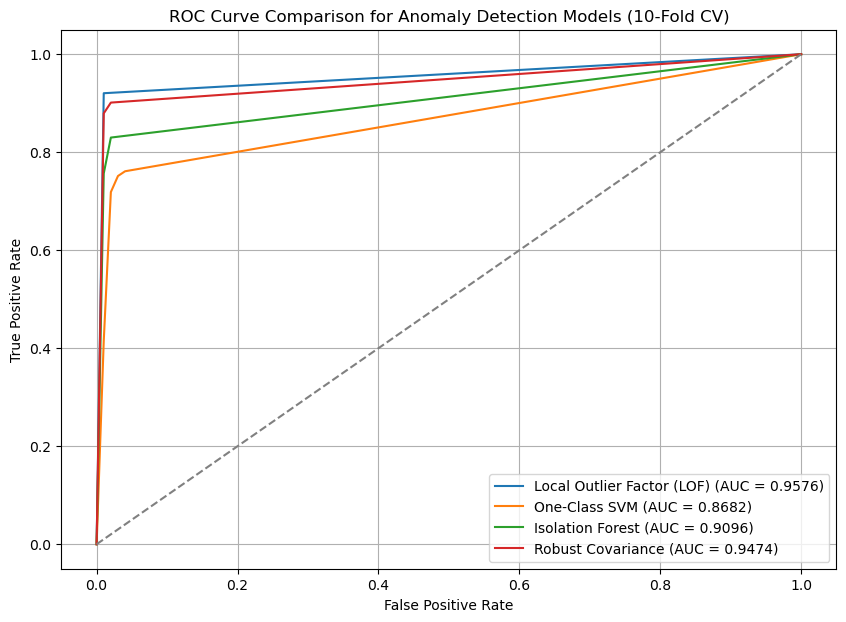

In [4]:
# Plot ROC Curves
plt.figure(figsize=(10, 7))
for name, (fpr, tpr, auc_score) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison for Anomaly Detection Models (10-Fold CV)")
plt.legend()
plt.grid(True)
plt.show()

# 80/20 train-test split

C:\Users\Hp\AppData\Local\Temp\ipykernel_19916\405429041.py:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


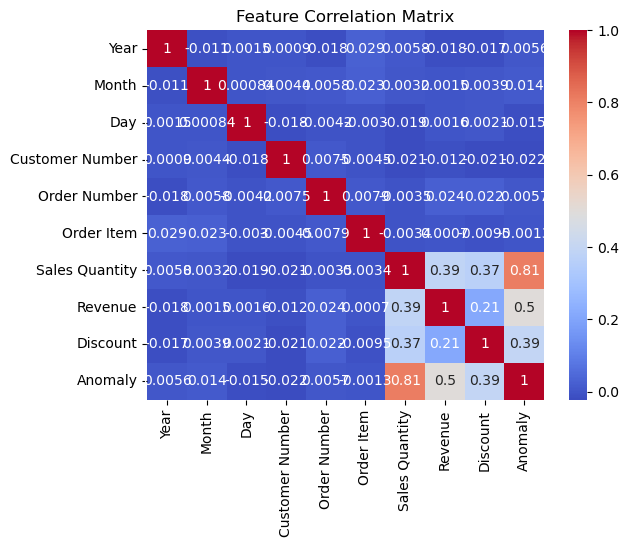


Training Local Outlier Factor (LOF)...
Accuracy: 0.9940
Precision: 0.9259
Recall: 0.9615
F1 Score: 0.9434
ROC AUC Score: 0.9787

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       948
           1       0.93      0.96      0.94        52

    accuracy                           0.99      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.99      0.99      0.99      1000


Training One-Class SVM...
Accuracy: 0.9730
Precision: 0.7119
Recall: 0.8077
F1 Score: 0.7568
ROC AUC Score: 0.8949

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       948
           1       0.71      0.81      0.76        52

    accuracy                           0.97      1000
   macro avg       0.85      0.89      0.87      1000
weighted avg       0.97      0.97      0.97      1000


Training Isolation Forest...
Accuracy: 0.9900
Precis

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-6.960166182837799 > -75.157050504170527). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-7.451682951567147 > -75.644290473317042). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-7.480220079744736 > -75.759318096964776). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
C:\Users\Hp\anacond

Accuracy: 0.9890
Precision: 0.9020
Recall: 0.8846
F1 Score: 0.8932
ROC AUC Score: 0.9397

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       948
           1       0.90      0.88      0.89        52

    accuracy                           0.99      1000
   macro avg       0.95      0.94      0.94      1000
weighted avg       0.99      0.99      0.99      1000



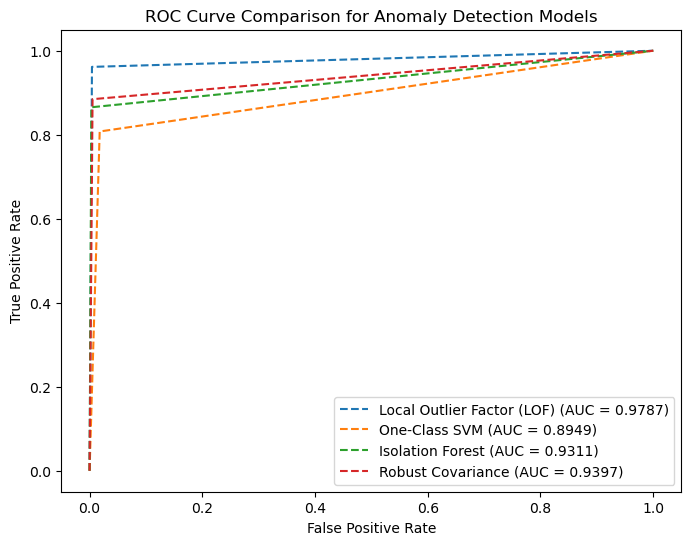

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve

# Load dataset
df = pd.read_csv("anomaly_dataset.csv")
df1=df
# Feature relevance analysis
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# Drop irrelevant or highly correlated features
df.drop(["Order Number", "Order Item", "Unit of Measure"], axis=1, inplace=True)

# Encode categorical variables
label_encoders = {}
for col in ["Currency", "Product"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Select features for anomaly detection
features = ["Year", "Month", "Day", "Customer Number", "Product", 
            "Sales Quantity", "Revenue", "Currency", "Discount"]

X = df[features]
y = df["Anomaly"]  # 0 = Normal, 1 = Anomaly

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Local Outlier Factor (LOF)": LocalOutlierFactor(n_neighbors=80, contamination=0.05, metric='manhattan', novelty=True),
    "One-Class SVM": OneClassSVM(nu=0.05, kernel="rbf", gamma="auto"),
    "Isolation Forest": IsolationForest(n_estimators=100, contamination=0.05, random_state=42),
    "Robust Covariance": EllipticEnvelope(contamination=0.05)
}

# Store results
evaluation_results = {}
roc_curves = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")

    if isinstance(model, LocalOutlierFactor):
        model.fit(X_train)
        y_pred_test = model.predict(X_test)
        y_pred_test = np.where(y_pred_test == -1, 1, 0)  # Convert -1 (outlier) → 1, 1 (inlier) → 0
    else:
        model.fit(X_train)
        y_pred_test = model.predict(X_test)
        y_pred_test = np.where(y_pred_test == -1, 1, 0)  # Convert -1 (outlier) → 1, 1 (inlier) → 0

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, zero_division=1)
    recall = recall_score(y_test, y_pred_test, zero_division=1)
    f1 = f1_score(y_test, y_pred_test, zero_division=1)
    roc_auc = roc_auc_score(y_test, y_pred_test)

    # Store results
    evaluation_results[name] = [accuracy, precision, recall, f1, roc_auc]

    # Print evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test, zero_division=1))

    # Store ROC curve data
    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    roc_curves[name] = (fpr, tpr, roc_auc)

# Plot ROC Curves for all models
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, linestyle='--', label=f"{name} (AUC = {auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison for Anomaly Detection Models")
plt.legend()
plt.show()


# Feature Importance

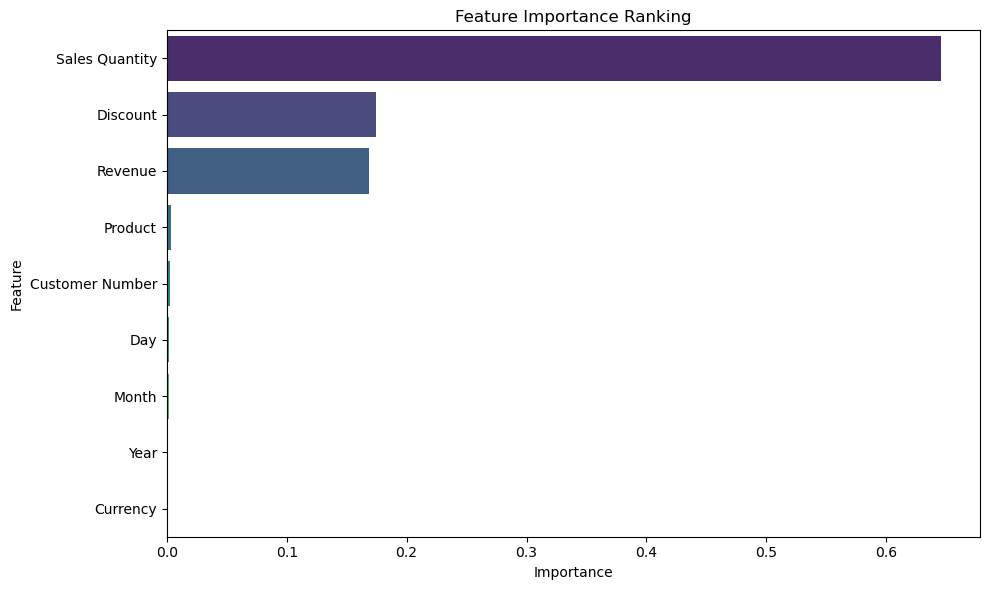

In [6]:
# Feature Importance

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume your features and target are:
X = df1.drop(columns=['Anomaly'])  # Drop the label column
y = df1['Anomaly']                 # Your label column

# Train a Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy plotting
feat_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances, palette='viridis')
plt.title('Feature Importance Ranking')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### With Feature Engineering

C:\Users\Hp\AppData\Local\Temp\ipykernel_19916\665981805.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


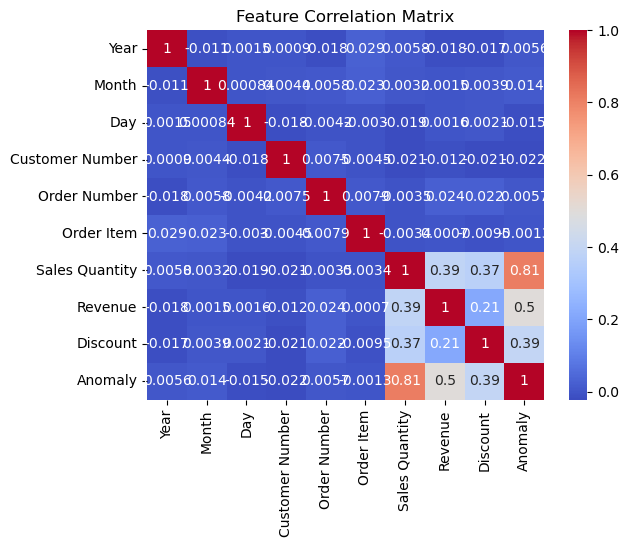


Evaluating Local Outlier Factor (LOF) with 10-Fold Cross Validation...
Accuracy: 0.9928
Precision: 0.9271
Recall: 0.9320
F1 Score: 0.9279
ROC AUC Score: 0.9640
Execution Time: 7.56 seconds

Evaluating One-Class SVM with 10-Fold Cross Validation...
Accuracy: 0.9718
Precision: 0.6993
Recall: 0.7840
F1 Score: 0.7371
ROC AUC Score: 0.8828
Execution Time: 1.39 seconds

Evaluating Isolation Forest with 10-Fold Cross Validation...
Accuracy: 0.9864
Precision: 0.8699
Recall: 0.8640
F1 Score: 0.8647
ROC AUC Score: 0.9284
Execution Time: 4.49 seconds

Evaluating Robust Covariance with 10-Fold Cross Validation...


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-8.705241594490445 > -75.529838532905757). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-7.362335934689037 > -75.500838044732021). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-7.142770468915030 > -75.534924853441638). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
C:\Users\Hp\anacond

Accuracy: 0.9874
Precision: 0.8753
Recall: 0.8760
F1 Score: 0.8742
ROC AUC Score: 0.9346
Execution Time: 8.66 seconds


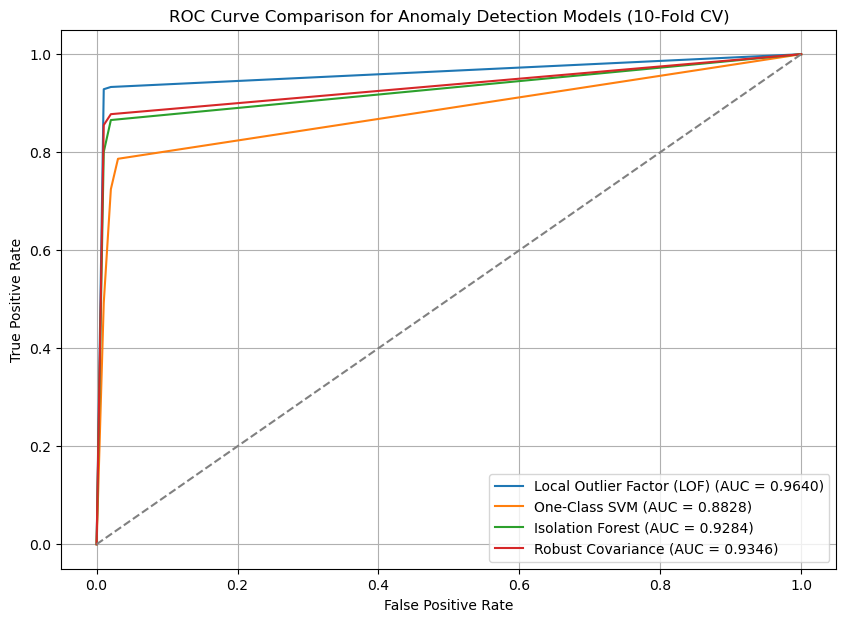

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve

# Load dataset
df = pd.read_csv("anomaly_dataset.csv")

# Feature relevance analysis
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# Drop irrelevant or highly correlated features
df.drop(["Order Number", "Order Item", "Unit of Measure"], axis=1, inplace=True)

# Encode categorical variables
label_encoders = {}
for col in ["Currency", "Product"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Select features for anomaly detection
features = ["Year", "Month", "Day", "Customer Number", "Product", 
            "Sales Quantity", "Revenue", "Currency", "Discount"]

X = df[features]
y = df["Anomaly"]  # 0 = Normal, 1 = Anomaly

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize models
models = {
    "Local Outlier Factor (LOF)": LocalOutlierFactor(n_neighbors=80, contamination=0.05, metric='manhattan', novelty=True),
    "One-Class SVM": OneClassSVM(nu=0.05, kernel="rbf", gamma="auto"),
    "Isolation Forest": IsolationForest(n_estimators=100, contamination=0.05, random_state=42),
    "Robust Covariance": EllipticEnvelope(contamination=0.05)
}

# Setting up 10-Fold Stratified Cross Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Storing results
evaluation_results = {}
roc_curves = {}


for name, model in models.items():
    print(f"\nEvaluating {name} with 10-Fold Cross Validation...")

    model_time = 0.0  # time spent on model training + prediction

    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    roc_aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    for train_index, test_index in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Timing the model's fit + predict process
        start = time.time()
        if isinstance(model, LocalOutlierFactor):
            model.fit(X_train)
            y_pred_test = model.predict(X_test)
        else:
            model.fit(X_train)
            y_pred_test = model.predict(X_test)
        end = time.time()

        model_time += (end - start)  # Add this fold's model time

        # Convert predictions to binary
        y_pred_test = np.where(y_pred_test == -1, 1, 0)

        # Performance metrics
        accuracies.append(accuracy_score(y_test, y_pred_test))
        precisions.append(precision_score(y_test, y_pred_test, zero_division=1))
        recalls.append(recall_score(y_test, y_pred_test, zero_division=1))
        f1s.append(f1_score(y_test, y_pred_test, zero_division=1))
        roc_aucs.append(roc_auc_score(y_test, y_pred_test))

        fpr, tpr, _ = roc_curve(y_test, y_pred_test)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(roc_aucs)
    roc_curves[name] = (mean_fpr, mean_tpr, mean_auc)

    # Average metrics
    evaluation_results[name] = [
        np.mean(accuracies),
        np.mean(precisions),
        np.mean(recalls),
        np.mean(f1s),
        np.mean(roc_aucs),
        model_time  
    ]

    # Print evaluation
    print(f"Accuracy: {np.mean(accuracies):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f}")
    print(f"F1 Score: {np.mean(f1s):.4f}")
    print(f"ROC AUC Score: {np.mean(roc_aucs):.4f}")
    print(f"Execution Time: {model_time:.2f} seconds")


    
# Plot ROC Curves
plt.figure(figsize=(10, 7))
for name, (fpr, tpr, auc_score) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison for Anomaly Detection Models (10-Fold CV)")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
summary_df = pd.DataFrame.from_dict(
    evaluation_results,
    orient='index',
    columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Time (s)']
)


print("\n\nSummary of Model Performance (Time Measured for Model Execution Only):")
print(summary_df)




Summary of Model Performance (Time Measured for Model Execution Only):
                            Accuracy  Precision  Recall  F1 Score   ROC AUC  \
Local Outlier Factor (LOF)    0.9928   0.927129   0.932  0.927893  0.964000   
One-Class SVM                 0.9718   0.699265   0.784  0.737066  0.882842   
Isolation Forest              0.9864   0.869883   0.864  0.864715  0.928421   
Robust Covariance             0.9874   0.875283   0.876  0.874213  0.934632   

                            Time (s)  
Local Outlier Factor (LOF)  7.557480  
One-Class SVM               1.392543  
Isolation Forest            4.486553  
Robust Covariance           8.658995  


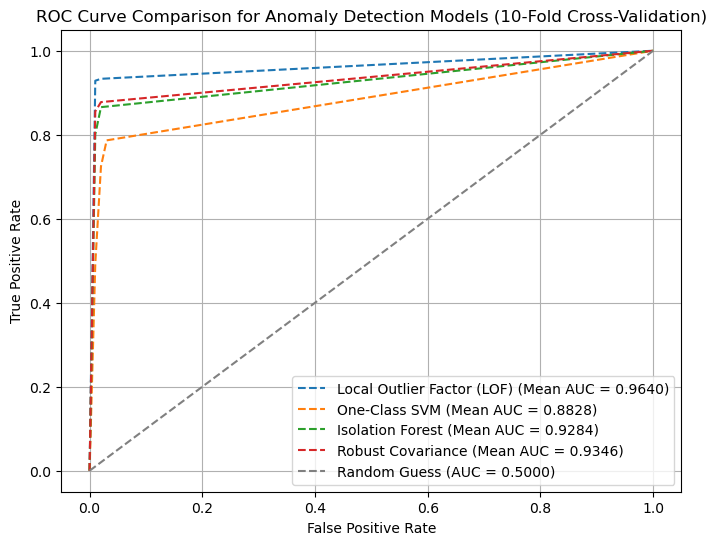

In [9]:
# Plot ROC Curves for all models (10-fold Cross-Validation)
plt.figure(figsize=(8, 6))

# Plot each model's averaged ROC curve
for name, (mean_fpr, mean_tpr, mean_auc) in roc_curves.items():
    plt.plot(mean_fpr, mean_tpr, linestyle='--', label=f"{name} (Mean AUC = {mean_auc:.4f})")

# Add a Random Guess Line (Baseline)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess (AUC = 0.5000)")

# Formatting the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison for Anomaly Detection Models (10-Fold Cross-Validation)")
plt.legend()
plt.grid(True)
plt.show()
